in this class wwe goan cover the function calling in gpt


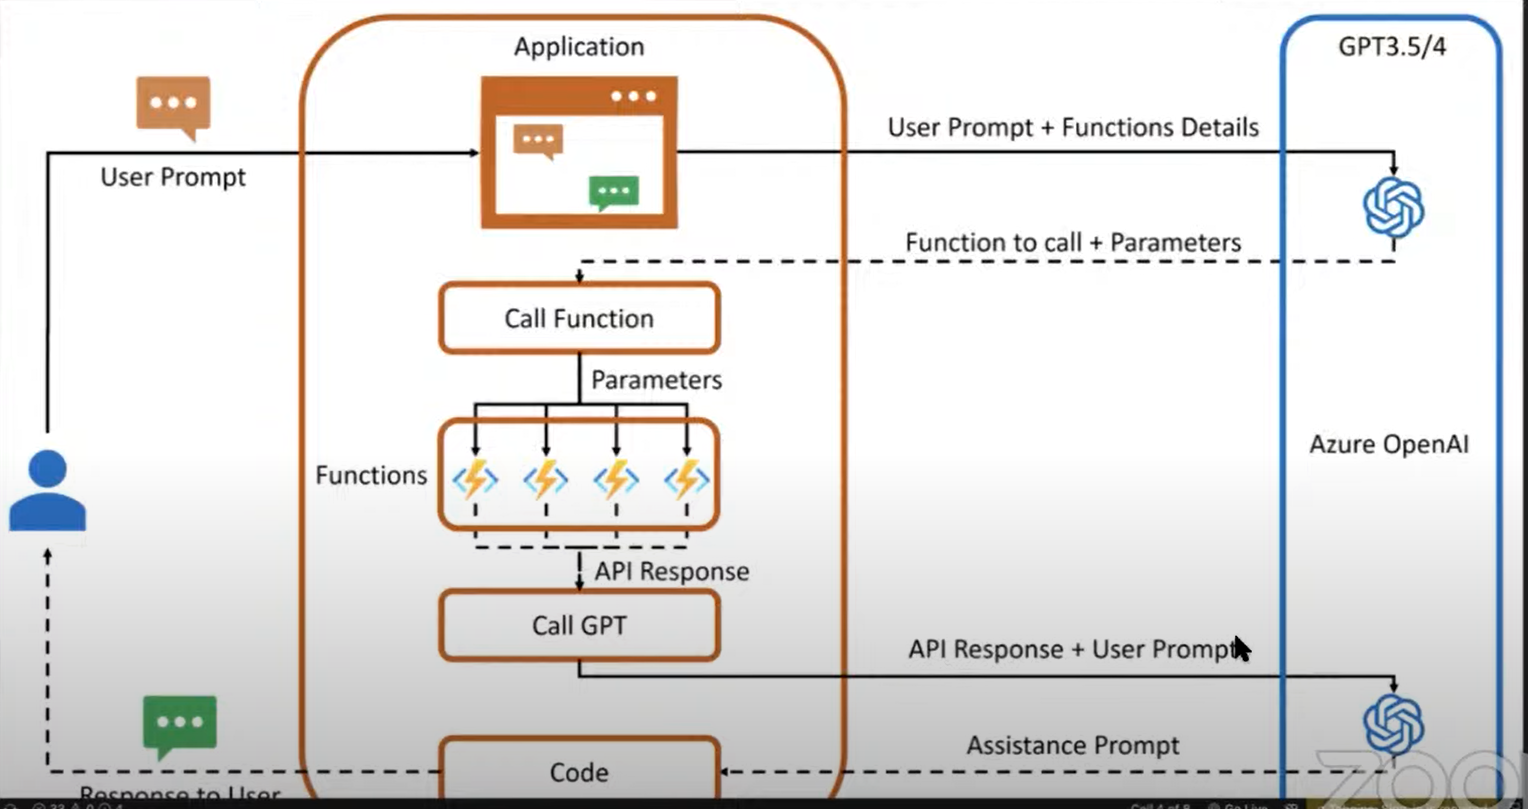

In [2]:
#now making the client first
from dotenv import find_dotenv, load_dotenv
from openai import OpenAI

_: bool = load_dotenv(find_dotenv())

client : OpenAI = OpenAI()

In [3]:
## now creating the custion function 
import json
def get_current_weather(location:str , unit:str = "fahrenheit") ->str:
    """Get the current weather in the given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location":"Tokyo","temperature":"10","unit":"celsius"})
    elif "san francisco" in location.lower():
        return json.dumps({"location":"San francisco","temperature":"72","unit":"fahrenheit"})
    elif "paris" in location.lower():
        return json.dumps({"location":"Paris","temperature":"22","unit":"celsius"})
    else:
        return json.dumps({"location":"location","temperature":"unknown"})

In [10]:
## now creating the main chatcompletion function
from openai.types.chat.chat_completion import ChatCompletion,ChatCompletionMessage

def run_conversation(main_request:str )->str :
    #step 1 : send the conversation and the avalible function to the model
    messages=[{"role":"user", "content":main_request}]
    #now in the tools we have to expalin the whole function
    tools =[
        {
            "type":"function",
            "function":{
                "name":"get_current_weather",
                "description":"Get the current weather in the given location",
                "perameters":{
                    "type":"object",
                    "properties":{
                        "location":{
                            "type":"string",
                            "description":"The city and the state ,eg ,San Francisco,tokyo etc",

                        },
                        "unit":{
                            "type":"string", "enum":["celsius" , "fahrenheit" ]
                        }
                    },
                    "required":["location"],
                }
            }

    }]

    #now creating the first request
    response : ChatCompletion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        tools = tools,
        tool_choice="auto",
    )

    #now we gona display the whole first responce
    response_message : ChatCompletionMessage = response.choices[0].message
    display("*First response :",dict(response_message))

    ##now from the whole first responce we gona display the tools calls only contians the all 
    #data about our functions
    tool_calls = response_message.tool_calls
    display("*First response tools calls :",list(tool_calls))


    #Now step no 2 : cheak if the model wanted to call a function

    if tool_calls:
        #step3 : call a function
        #Note:the json response isn not always be valid :be sure to handle errors
        avalible_functions = {
            "get_current_weather": get_current_weather
        }#there is only the one function in this exampleu may have multiple

        messages.append(response_message) #extend conversation with assistant reply

        #step4 : send the info for each function call and function response to the model

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = avalible_functions[function_name]
            function_args= json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                location = function_args.get("location"),
                unit = function_args.get("unit"),
            )
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role":"tool",
                    "name":function_name,
                    "content":function_response,

                }
            )#extend the conversation with function response

        display("Second request message",list(messages))

        second_response:ChatCompletion= client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,

        )
        print ("second response", dict(second_response))

        return second_response.choices[0].message.content



In [11]:
run_conversation("what is the weather in San Francisco , tokyo ans paris?")

'*First response :'

{'content': None,
 'role': 'assistant',
 'function_call': None,
 'tool_calls': [ChatCompletionMessageToolCall(id='call_wWSHm99Lzcxj4VnM45wm3Erp', function=Function(arguments='{"location": "San Francisco"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_11CsbAs6P5gycVO6jIb5qrwS', function=Function(arguments='{"location": "Tokyo"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_mtUduDkITjZaXrgSYjmsdltK', function=Function(arguments='{"location": "Paris"}', name='get_current_weather'), type='function')]}

'*First response tools calls :'

[ChatCompletionMessageToolCall(id='call_wWSHm99Lzcxj4VnM45wm3Erp', function=Function(arguments='{"location": "San Francisco"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_11CsbAs6P5gycVO6jIb5qrwS', function=Function(arguments='{"location": "Tokyo"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_mtUduDkITjZaXrgSYjmsdltK', function=Function(arguments='{"location": "Paris"}', name='get_current_weather'), type='function')]

'Second request message'

[{'role': 'user',
  'content': 'what is the weather in San Francisco , tokyo ans paris?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_wWSHm99Lzcxj4VnM45wm3Erp', function=Function(arguments='{"location": "San Francisco"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_11CsbAs6P5gycVO6jIb5qrwS', function=Function(arguments='{"location": "Tokyo"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_mtUduDkITjZaXrgSYjmsdltK', function=Function(arguments='{"location": "Paris"}', name='get_current_weather'), type='function')]),
 {'tool_call_id': 'call_wWSHm99Lzcxj4VnM45wm3Erp',
  'role': 'tool',
  'name': 'get_current_weather',
  'content': '{"location": "San francisco", "temperature": "72", "unit": "fahrenheit"}'},
 {'tool_call_id': 'call_11CsbAs6P5gycVO6jIb5qrwS',
  'role': 'tool',
  'name': 'get_current_weather',
  'content': '{"loca

second response {'id': 'chatcmpl-98kjrLVrfSXzW0hetDt0FnI43BIo0', 'choices': [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The current weather in San Francisco is 72°F, in Tokyo it is 10°C, and in Paris it is 22°C.', role='assistant', function_call=None, tool_calls=None))], 'created': 1711873315, 'model': 'gpt-3.5-turbo-0125', 'object': 'chat.completion', 'system_fingerprint': 'fp_3bc1b5746c', 'usage': CompletionUsage(completion_tokens=28, prompt_tokens=155, total_tokens=183)}


'The current weather in San Francisco is 72°F, in Tokyo it is 10°C, and in Paris it is 22°C.'